In [1]:
import json
import mnist
import random
import scipy

import numpy as np
import matplotlib.pyplot as plt

from skimage import color
from skimage import io
from skimage import filters, feature

from sklearn.utils import shuffle
from sklearn import svm

from matplotlib import image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, AveragePooling2D
from keras.datasets import cifar10

from tensorflow.keras.utils import to_categorical    

from scripts.load_data import load_train, load_test

# Loading data

This code is used to load the data from the assets directory

In [56]:
images = []
bunnies = []

data = None
with open("../../Boundary_Box/coordinates.json", 'r+') as file:
    data = json.loads(file.read())
    
    for jpg in data:
        for coords in data[jpg]:
            im = color.rgb2gray(io.imread(f"../../Boundary_Box/assets/{jpg}"))
            x_coords = [coords['begin'][0], coords['end'][0]]
            y_coords = [coords['begin'][1], coords['end'][1]]

            images.append(im)
            bunnies.append(im[ min(y_coords) : max(y_coords) , min(x_coords) : max(x_coords) ])


# Utility functions

This code can be used as utility later on

In [214]:
def max_pooling(image, n):
    shape = image.shape
    output = np.zeros((shape[0]//n, shape[1]//n))
    
    for y in range(1, shape[1]-1, n):
        for x in range(1, shape[0]-1, n):
            region = image[x-(n//2):x+((n//2)+1), y-(n//2):y+((n//2)+1)]
            output[(x-1)//n, (y-1)//n] = region.max()

    return output

# Filters

This code is used to test if there is a different way to make some features more visible to use as patches, instead of just using black and white images.

* **Obeservations:**\
It looks like that using a smooth filter where the selected pixel weighs more than the rest, combined with a laplacian filter from the scipy library seems to really enhance subtle features.

* **Conclusion:**\
I will be using the combination of a smooth filter with a laplacian filter to extract patches and train the neural network.

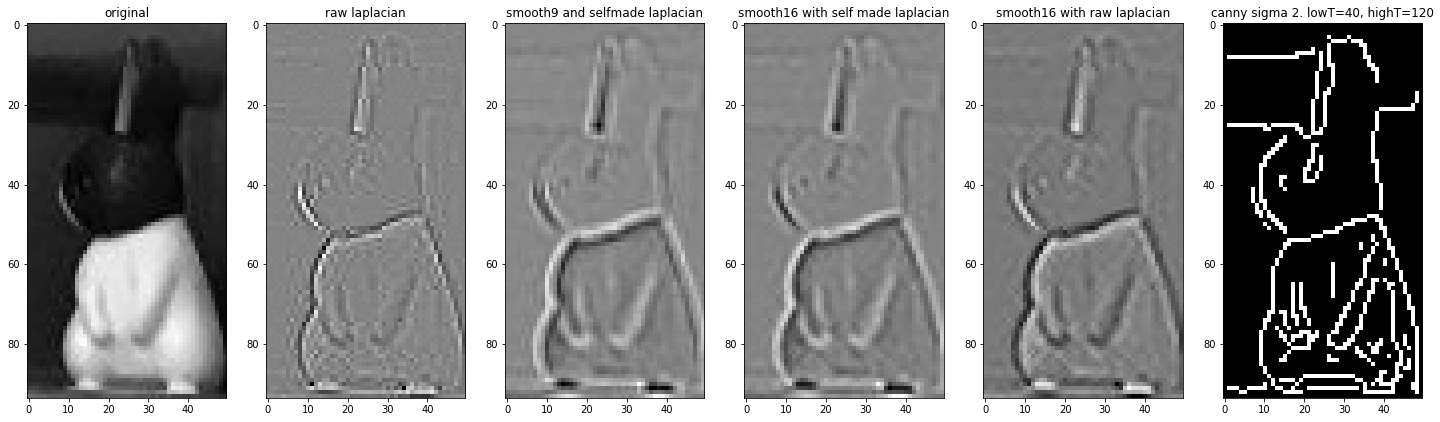

In [3]:
im = images[230]
b = bunnies[230]

smooth_mean_1=[ [1/9,1/9,1/9],
              [1/9,1/9,1/9],
              [1/9,1/9,1/9]]

smooth_mean_2=[ [1/16,1/16,1/16],
              [1/16,1/5,1/16],
              [1/16,1/16,1/16]]

laplacian=[ [0.5,1,0.5],
            [1,-6,1],
            [0.5,1,0.5]]
            
laplace_im = filters.laplace(b)

smoothIMG=scipy.ndimage.convolve(b, smooth_mean_1)
laplacianIMG=scipy.ndimage.convolve(smoothIMG, laplacian)
laplacianIMG += 127

smoothIMG2=scipy.ndimage.convolve(b, smooth_mean_2)
laplacian2=scipy.ndimage.convolve(smoothIMG2, laplacian)
laplacian2 += 127

smoothIMG3=scipy.ndimage.convolve(b, smooth_mean_2)
laplacian3=filters.laplace(smoothIMG3)




fig, ax = plt.subplots(1,6, figsize=(25, 8))
ax[0].imshow(b, cmap='gray')
ax[0].set_title("original")

ax[1].imshow(laplace_im, cmap='gray')
ax[1].set_title("raw laplacian")

ax[2].imshow(laplacianIMG, cmap='gray')
ax[2].set_title("smooth9 and selfmade laplacian")

ax[3].imshow(laplacian2, cmap='gray')
ax[3].set_title("smooth16 with self made laplacian")

ax[4].imshow(laplacian3, cmap='gray')
ax[4].set_title("smooth16 with raw laplacian")

ax[5].imshow(feature.canny(b, sigma=0.5), cmap='gray')
ax[5].set_title("canny sigma 2. lowT=40, highT=120")

plt.show()

# Patch selection

This code is used to test to see if I can select patches from the boundary boxes.

* **Result:**\
I used an edge detection filter on the image and boundary box image, then I managed to create 50 patches from within the boundary box, and 50 outside of it.

In [57]:
# pic_num = random.sample(range(0, len(images)), len(images)-1)

patch_size = 20 # (N x N) pixels
patches, labels = [], []

smooth_filter = [ 
    [1/16,1/16,1/16],
    [1/16,1/5,1/16],
    [1/16,1/16,1/16]
]

for i in range(len(images)):
    im = images[i]
    bunny = bunnies[i]

    # smooth_bunny=scipy.ndimage.convolve(bunny, smooth_filter)
    # bunny=filters.laplace(smooth_bunny)

    # smooth_image=scipy.ndimage.convolve(im, smooth_filter)
    # im=filters.laplace(smooth_image)

    for j in range(50):

        # boundary box coordinates
        x_b = random.randint((patch_size//2)+1, bunny.shape[0]-(patch_size//2))
        y_b = random.randint((patch_size//2)+1, bunny.shape[1]-(patch_size//2))

        x_coords_b = [x_b-patch_size//2, x_b+patch_size//2]
        y_coords_b = [y_b-patch_size//2, y_b+patch_size//2]

        patch_b = bunny[  min(x_coords_b) : max(x_coords_b), min(y_coords_b) : max(y_coords_b) ]
        patches.append(patch_b)
        labels.append(1)
        
        ##############################################################################################################

        # outside boundary box coordinates range
        x_range = [x for x in range((patch_size//2), im.shape[0]-(patch_size//2))]
        y_range = [y for y in range((patch_size//2), im.shape[1]-(patch_size//2))]

        # remove subsection of the boundary box from the list with all coordinates
        name = list(data.keys())[i]
        y_coords_data_arrays = [data[name][0]['begin'][0], data[name][0]['end'][0]]
        x_coords_data_arrays = [data[name][0]['begin'][1], data[name][0]['end'][1]]

        del x_range[min(x_coords_data_arrays)-(patch_size//2)+1 : max(x_coords_data_arrays)+(patch_size//2)]
        del y_range[min(y_coords_data_arrays)-(patch_size//2)+1 : max(y_coords_data_arrays)+(patch_size//2)]

        #pick random coordinate
        x = random.choice(y_range)
        y = random.choice(x_range)

        x_coords = [x-patch_size//2, x+patch_size//2]
        y_coords = [y-patch_size//2, y+patch_size//2]

        patch_pic = im[ min(y_coords) : max(y_coords), min(x_coords) : max(x_coords) ]
        patches.append(patch_pic)
        labels.append(0)

        ##############################################################################################################


        ############## VISUALIZATION ###############
        # fig, ax = plt.subplots(2, 2, figsize=(12, 13))

        
        # ax[0,0].imshow(patch_pic, cmap='gray')
        # ax[0,0].set_title(f"Patch outside boundary box")

        # ax[0,1].imshow(images[i], cmap='gray')
        # ax[0,1].set_title(f"{list(data.keys())[i]}")

        # ax[0,1].scatter(x=[x_coords[0], x_coords[1]], y=[y_coords[0], y_coords[1]], c='b')
        # ax[0,1].scatter(x=[y_coords_data_arrays[0], y_coords_data_arrays[1]], y=[x_coords_data_arrays[0], x_coords_data_arrays[1]], c='r')

        # ax[1,0].imshow(patch_b, cmap='gray')
        # ax[1,0].set_title(f"Patch within boundary box")

        # ax[1,1].imshow(bunnies[i], cmap='gray')
        # ax[1,1].set_title(f"Boundary box content")
        # ax[1,1].scatter(x=[y_coords_b[0], y_coords_b[1]], y=[x_coords_b[0], x_coords_b[1]], c='r')
        
        # plt.show()

        ############################################




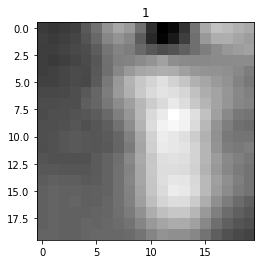

In [68]:
fig, ax = plt.subplots(1)
ax.imshow(patches[110], cmap='gray')
ax.set_title(f"{labels[110]}")

plt.show()

# Neural networks
This code is used to train neural networks

### Loading test- and train data/labels

(16200, 20, 20, 1)


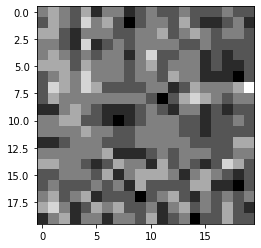

In [69]:
data_arr, label = np.array(patches), np.array(labels)

data_arr, label = shuffle(data_arr, label)

len_data = len(data_arr)

train_data = data_arr[:len_data//3 *2]
train_labels = label[:len_data//3 *2]

test_data = data_arr[len_data//3 *2:]
test_labels = label[len_data//3 *2:]

# Normalizeren van de images
train_data = (train_data / 255) - 0.5
test_data = (test_data / 255) - 0.5

# Reshapen van de images zodat ze de juiste dimensies hebben
train_data = np.expand_dims(train_data, axis=3)
test_data = np.expand_dims(test_data, axis=3)
print(train_data.shape)

plt.imshow(test_data[50], cmap='gray')

## Creating a SVM model
This code is used to train a SVM

In [16]:
x = len(train_data[0])
y = len(train_data[0][0])

train_data2 = np.reshape(train_data, (len(train_data), x*y) )
test_data2 = np.reshape(test_data, (len(test_data), x*y) )

print(train_data2.shape)

(16200, 400)


In [23]:
clf = svm.SVC(gamma='scale', C=100)

clf.fit(train_data2, train_labels)

correct = 0
for i, data in enumerate(test_data2):
    res = clf.predict([data])
    if res[0] == test_labels[i]:
        correct += 1

print("Accuracy =", round((correct/len(test_data2))*100, 2) )

Accuracy = 71.37


## Creating the CNN model

In [70]:
shape = train_data.shape
num_filters = 40
filter_size = 6
pool_size = 2


model = Sequential([
    Conv2D(30, (filter_size, filter_size), input_shape=(shape[1], shape[2], shape[3]), padding='same'),
    Conv2D(30, (filter_size, filter_size), padding='same'),
    MaxPooling2D(pool_size=pool_size),
    Conv2D(30, (10, 10), padding='same'),

    Flatten(None),
    Dense(15, activation='relu'),
    Dense(2, activation='softmax')

])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 20, 20, 30)        1110      
                                                                 
 conv2d_23 (Conv2D)          (None, 20, 20, 30)        32430     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 10, 10, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 10, 10, 30)        90030     
                                                                 
 flatten_9 (Flatten)         (None, 3000)              0         
                                                                 
 dense_10 (Dense)            (None, 15)                45015     
                                                      

### Compiling and fitting

In [71]:

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_data, to_categorical(train_labels), epochs=7)
validation_data = train_data, to_categorical(test_labels)

Epoch 1/7
507/507 [==============================] - 46s 89ms/step - loss: 0.6954 - accuracy: 0.5053
Epoch 2/7
507/507 [==============================] - 55s 109ms/step - loss: 0.6931 - accuracy: 0.5062
Epoch 3/7
507/507 [==============================] - 50s 98ms/step - loss: 0.6932 - accuracy: 0.5006
Epoch 4/7
507/507 [==============================] - 52s 103ms/step - loss: 0.6931 - accuracy: 0.5033
Epoch 5/7
214/507 [===========>..................] - ETA: 28s - loss: 0.6932 - accuracy: 0.5039

KeyboardInterrupt: 

In [51]:
test_loss, test_acc = model.evaluate(test_data, to_categorical(test_labels), verbose=2)
print(test_acc)

254/254 - 1s - loss: 0.6932 - accuracy: 0.4991 - 1s/epoch - 6ms/step
0.4991357922554016
